In [23]:

import tensorflow as tf  ### models
import numpy as np     ### math computations
import matplotlib.pyplot as plt ### plots
import sklearn  ### machine learning library
import cv2  ## image processing
from sklearn.metrics import confusion_matrix, roc_curve ### metrics
import seaborn as sns   ### visualizations
import datetime
import io
import os
import random
from PIL import Image
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
from tensorboard.plugins.hparams import api as hp

In [24]:
os.environ["LD_LIBRARY_PATH"] = "/usr/lib/x86_64-linux-gnu/"

In [25]:
dataset,dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])
#show devices available
print("Devices Available: ", tf.config.list_physical_devices())

Devices Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [26]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
    val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))
    test_dataset = val_test_dataset.skip(int(TEST_RATIO * DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset

In [27]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

#dataset = tf.data.Dataset.range(10)
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
# print(list(train_dataset.take(1).as_numpy_iterator()))
# print(list(val_dataset.take(1).as_numpy_iterator()))
# print(list(test_dataset.take(1).as_numpy_iterator()))

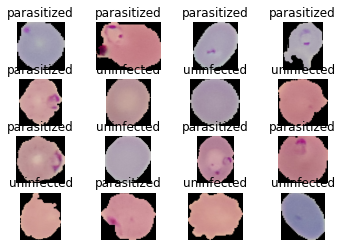

In [28]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis("off")

In [29]:
def resize_rescale(image, label):
    image = tf.image.resize(image, (224, 224))/255.0
    return image, label

In [30]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)
IM_SIZE = 224
train_dataset = train_dataset.shuffle(buffer_size = 8,
                                      reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size = 8,
                                      reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size = 8,
                                      reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)



In [31]:
val_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [32]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [33]:


lunet_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation='relu', input_shape=(IM_SIZE, IM_SIZE, 3)),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation='relu'),
    MaxPool2D(pool_size = 2, strides = 2),
    BatchNormalization(),
    Flatten(),

    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),

])
lunet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_24 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 111, 111, 6)      0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 54, 54, 16)       0         
 g2D)                                                            
                                                      

In [34]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = 'input_image')

x = Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation='relu', input_shape=(IM_SIZE, IM_SIZE, 3))(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2)(x)

x = Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2)(x)

output = x

feature_extractor = Model(func_input, output, name='Feature_Extractor')
feature_extractor.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_28 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 111, 111, 6)      0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_29 (Bat  (None, 109, 109, 16

In [35]:
feature_extractor_seq_model = tf.keras.Sequential([
                            InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
                            Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation='relu', input_shape=(IM_SIZE, IM_SIZE, 3)),
                            BatchNormalization(),
                            MaxPool2D(pool_size = 2, strides = 2),
                            Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation='relu'),
                            BatchNormalization(),
                            MaxPool2D(pool_size = 2, strides = 2),
])

feature_extractor_seq_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_30 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 111, 111, 6)      0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_31 (Bat  (None, 109, 109, 16)     64        
 chNormalization)                                                
                                                      

In [36]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = 'input_image')

x = feature_extractor(func_input)

x = Flatten()(x)

x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(1, activation='sigmoid')(x)
func_output = x

lunet_model_func = Model(func_input, func_output, name='lunet_model')
lunet_model_func.summary()

Model: "lunet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Feature_Extractor (Function  (None, 54, 54, 16)       1136      
 al)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 46656)             0         
                                                                 
 dense_18 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_32 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_19 (Dense)            (None, 10)                

In [37]:

class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size,):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D (pool_size = pool_size, strides= 2*strides)

    self.conv_2 = Conv2D(filters = filters*2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D (pool_size = pool_size, strides= 2*strides)

  def call(self, x, training):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x
feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [38]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = 'input_image')

x = feature_sub_classed(func_input)

x = Flatten()(x)

x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(1, activation='sigmoid')(x)
func_output = x

lunet_model_func = Model(func_input, func_output, name='lunet_model')
lunet_model_func.summary()

Model: "lunet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor_4 (Featur  (None, 54, 54, 16)       1488      
 eExtractor)                                                     
                                                                 
 flatten_7 (Flatten)         (None, 46656)             0         
                                                                 
 dense_21 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_36 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_22 (Dense)            (None, 10)                

In [39]:

class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()
    self.feature_extractor = FeatureExtractor(8,3,1,"valid","relu",2)
    self.flatten = Flatten()
    self.dense_1 = Dense(100, activation='relu')
    self.batch_1 = BatchNormalization()
    self.dense_2 = Dense(10, activation='relu')
    self.batch_2 = BatchNormalization()
    self.dense_3 = Dense(1, activation='sigmoid')

  def call(self, x, training):
    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)
    return x
    
lenet_sub_classed_model = LenetModel()
lenet_sub_classed_model(tf.zeros((1, IM_SIZE, IM_SIZE, 3)))
lenet_sub_classed_model.summary()

Model: "lenet_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_5 (Featur  multiple                 1488      
 eExtractor)                                                     
                                                                 
 flatten_8 (Flatten)         multiple                  0         
                                                                 
 dense_24 (Dense)            multiple                  4665700   
                                                                 


 batch_normalization_40 (Bat  multiple                 400       
 chNormalization)                                                
                                                                 
 dense_25 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_41 (Bat  multiple                 40        
 chNormalization)                                                
                                                                 
 dense_26 (Dense)            multiple                  11        
                                                                 
Total params: 4,668,649
Trainable params: 4,668,381
Non-trainable params: 268
_________________________________________________________________


In [40]:
lenet_sub_classed_model.compile(optimizer= Adam(learning_rate=0.01),
              loss = BinaryCrossentropy(),
               metrics= ['accuracy'])

In [41]:
history = lenet_sub_classed_model.fit(train_dataset, validation_data=val_dataset, epochs=3, verbose = 1)

Epoch 1/20
149/689 [=====>........................] - ETA: 12s - loss: 0.6059 - accuracy: 0.6791

KeyboardInterrupt: 

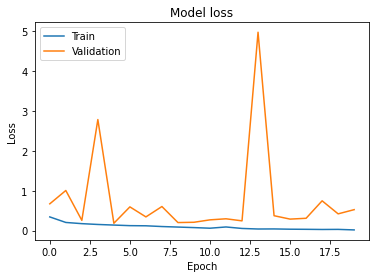

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
lunet_model.evaluate(test_dataset)

87/87 [==============================] - 3s 12ms/step - loss: 0.5032 - accuracy: 0.8799


[0.5032320022583008, 0.8799419403076172]

In [ ]:
def parasite_or_not(x):
    if(x<0.5):
        return str('P')
    else:
        return str('U')

In [ ]:
parasite_or_not(lunet_model.predict(test_dataset.take(1))[0][0])

'P'

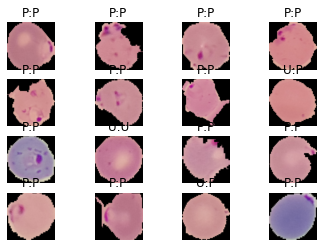

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image[0])
    plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(lunet_model.predict(image)[0][0])))
    plt.axis("off")